## Immune biomarker correlation

In this notebook, we look at the correlation between UPS mutations and immune-related biomarkers.

In [2]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import utils
import rpy2
%load_ext rpy2.ipython

The first step is to read in the mutation data. 

In [17]:
# read in how many mutations for each analysis
output_list = []
for f in glob.glob('data/ups_driver_gene/mutation_flags/*.txt'):
    ctype = os.path.basename(f)[:-4]
    tmp = pd.read_table(f, index_col=0)
    tmp_sum = tmp.sum()
    for gene in tmp_sum.index:
        output_list.append([gene, ctype, tmp_sum.loc[gene]])
mut_ct_df = pd.DataFrame(output_list, columns=['gene', 'cancer type', 'count'])

### Correlation of UPS mutations with immune biomarkers



In [25]:
signif_immune, heatmap_df = utils.read_immune_data(mut_ct_df, 'data/immune/immune_correlation_mutation.txt')

Text(50.9427,0.5,'')

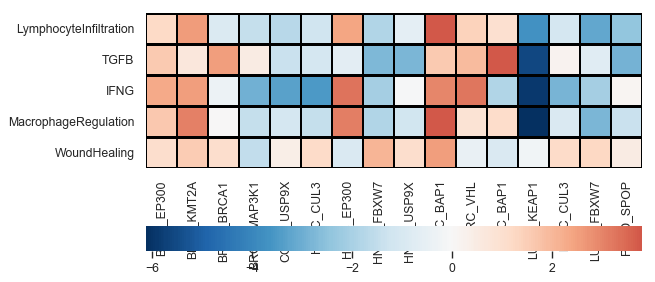

In [26]:
# plot heatmap
variable_list = ['LymphocyteInfiltration', 'TGFB', 'IFNG', 'MacrophageRegulation', 'WoundHealing']
cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(heatmap_df.loc[variable_list], square=True, cmap='RdBu_r', 
                center=0, linewidth=1, linecolor='black',
                cbar=True, 
                cbar_kws={"orientation": "horizontal", 
                          #'use_gridspec':False, 
                          #'location':"top"
                         })


plt.xlabel('')
plt.ylabel('')

### KEAP1 correlation with immune biomarkers

Next, we look at a specific example of KEAP1.

In [27]:
# read in immune association
immune_df = pd.read_table('data/immune/keap1_immune_correlation.txt')
split = immune_df.analysis.str.split('_', expand=True).rename(columns={0: 'cancer type', 1: 'gene'})
immune_df = pd.concat([immune_df, split], axis=1)
#immune_df = pd.merge(immune_df, mut_ct_df, on=['gene', 'cancer type'], how='left')

# perform analysis of immune-related biomarkers
lf_df = immune_df[(immune_df['variable']=='LeukocyteFraction')].copy()
lf_df['qvalue'] = utils.bh_fdr(lf_df['pvalue'])
tgfb_df = immune_df[(immune_df['variable']=='TGFB')].copy()
tgfb_df['qvalue'] = utils.bh_fdr(tgfb_df['pvalue'])
ifng_df = immune_df[(immune_df['variable']=='IFNG')].copy()
ifng_df['qvalue'] = utils.bh_fdr(ifng_df['pvalue'])
macrophage_df = immune_df[(immune_df['variable']=='MacrophageRegulation')].copy()
macrophage_df['qvalue'] = utils.bh_fdr(macrophage_df['pvalue'])
wound_df = immune_df[(immune_df['variable']=='WoundHealing')].copy()
wound_df['qvalue'] = utils.bh_fdr(wound_df['pvalue'])
lymph_df = immune_df[(immune_df['variable']=='LymphocyteInfiltration')].copy()
lymph_df['qvalue'] = utils.bh_fdr(lymph_df['pvalue'])
leuk_df = immune_df[(immune_df['variable']=='LeukocyteFraction')].copy()
leuk_df['qvalue'] = utils.bh_fdr(leuk_df['pvalue'])

In [29]:
qval_thresh = 0.1
signif_immune = pd.concat([
     lymph_df[lymph_df['qvalue']<qval_thresh],
     leuk_df[leuk_df['qvalue']<qval_thresh],
     tgfb_df[tgfb_df['qvalue']<qval_thresh],
     ifng_df[ifng_df['qvalue']<qval_thresh],
     macrophage_df[macrophage_df['qvalue']<qval_thresh],
     wound_df[wound_df['qvalue']<qval_thresh]
])
uniq_signif = signif_immune['analysis'].unique()
variable_list = ['LymphocyteInfiltration', 'TGFB', 'IFNG', 'MacrophageRegulation', 'WoundHealing']


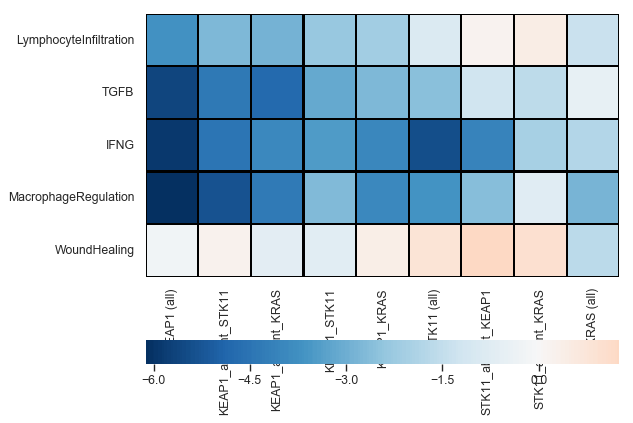

In [30]:
# plot heatmap
is_variable = immune_df['variable'].isin(variable_list)
is_signif = immune_df['analysis'].isin(uniq_signif)
plot_df = immune_df[is_variable & is_signif].pivot(index='variable', columns='analysis', values='tvalue')

# plot heatmap
#fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plot_df = plot_df.rename(columns={'KEAP1': 'KEAP1 (all)', 'STK11': 'STK11 (all)', 'KRAS': 'KRAS (all)'})
col_order = ['KEAP1 (all)', 'KEAP1_absent_STK11', 'KEAP1_absent_KRAS', 'KEAP1_STK11', 'KEAP1_KRAS',
             'STK11 (all)', 'STK11_absent_KEAP1', 'STK11_absent_KRAS', 'KRAS (all)']
g = sns.heatmap(plot_df.loc[variable_list, col_order], square=True, cmap='RdBu_r', 
                center=0, linewidth=1, linecolor='black',
                cbar=True, 
                cbar_kws={"orientation": "horizontal", 
                          #'use_gridspec':False, 
                          #'location':"top"
                         })

plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

plt.savefig('figures/keap1_immune_correlation.pdf')